In [1]:
import sys 

import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from math import sqrt

In [3]:
path = './dbs/handled/'
df_brazil_final = pd.read_csv(path + 'df_brazilian_states_cases.csv')
df_brazil_rolled = pd.read_csv(path + 'df_brazil_rolled_cases.csv')
df_seird = pd.read_csv(path + 'df_brazil_appllied_seird_model.csv')
df_parameters_seird = pd.read_csv(path + 'df_parameters_seird.csv', parse_dates=['Date'], index_col='Date')

In [4]:
df_parameters_seird

,holiday,R0,Rt,alpha,beta,epsilon,gamma,mu,R0_ma,Rt_ma,cases,deaths
Date,,,,,,,,,,,,
2020-02-26,1,1.059129,0.460340,0.331031,0.326627,0.198218,0.085822,0.623711,1.059129,0.460340,0,0
2020-02-27,1,1.059129,0.460340,0.331031,0.326627,0.198218,0.085822,0.623711,1.059129,0.460340,0,0
2020-02-28,1,3.107842,0.011379,0.166911,0.001227,0.516834,0.098784,0.009050,1.742033,0.310686,1,0
2020-02-29,1,1.059129,0.460340,0.331031,0.326627,0.198218,0.085822,0.623711,1.571307,0.348100,0,0
2020-03-01,1,1.059129,0.460340,0.331031,0.326627,0.198218,0.085822,0.623711,1.468871,0.370548,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28,0,1.403370,1.396835,0.401986,0.166542,0.002627,0.097925,0.021303,1.096815,0.813898,53888,2426
2021-05-29,0,1.541924,1.530616,0.250362,0.170621,0.002831,0.094727,0.016745,1.143145,0.886094,75863,1941
2021-05-30,0,1.646952,1.637185,0.498221,0.195238,0.004866,0.092661,0.026592,1.185132,0.969081,41449,913


In [5]:
holiday = ['2020-02-26',
           '2020-04-10',
           '2020-04-21',
           '2020-05-01',
           '2020-06-11',
           '2020-10-12',
           '2020-11-02',
           '2020-11-15',
           '2020-12-25',
           '2021-01-01',
           '2021-02-16',
           '2021-04-02',
           '2021-04-21',
           '2021-05-01']

canceled_holiday = ['2020-09-07']

elections = ['2020-11-15',
             '2020-11-29']

political_interventions = ['2020-04-16', #Mandetta left
                           '2020-05-15', #Teich left 
                           '2021-03-23'] #Pazuello left

restriction_flexibility = ['2020-08-01'] #Flexibilization in São Paulo
        
lockdown_ini = ['2020-05-05']#,'2020-11-01']
lockdown_end = ['2020-06-14']#,'2021-01-30']

In [6]:
moving_average=14

## Mobility Data

In [7]:
df_mobility = pd.read_csv('./dbs/brasil_df.csv', parse_dates=['date'], index_col='date')

first_day = df_parameters_seird.index.min()
last_day = df_parameters_seird.index.max()

df_mobility = df_mobility.loc[(df_mobility.index >= first_day) & (df_mobility.index <= last_day)]

In [8]:
# replacing accumulated cases by daily cases
df_mobility['cases'] = df_parameters_seird['cases']
df_mobility['deaths'] = df_parameters_seird['deaths']
df_mobility['holiday'] = df_parameters_seird['holiday']

In [9]:
df_mobility

,cases,deaths,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,holiday
date,,,,,,,,,
2020-02-26,0,0,-18.0,-11.0,-8.0,-17.0,-18.0,6.0,1
2020-02-27,0,0,-8.0,2.0,-11.0,1.0,10.0,1.0,1
2020-02-28,1,0,-5.0,3.0,-17.0,2.0,13.0,1.0,1
2020-02-29,0,0,-3.0,5.0,-23.0,-2.0,5.0,3.0,1
2020-03-01,0,0,-9.0,3.0,-34.0,-10.0,-1.0,5.0,1
...,...,...,...,...,...,...,...,...,...
2021-05-28,53888,2426,-19.0,35.0,-20.0,-9.0,5.0,8.0,0
2021-05-29,75863,1941,-20.0,33.0,-23.0,-10.0,9.0,7.0,0
2021-05-30,41449,913,-33.0,20.0,-36.0,-25.0,6.0,9.0,0


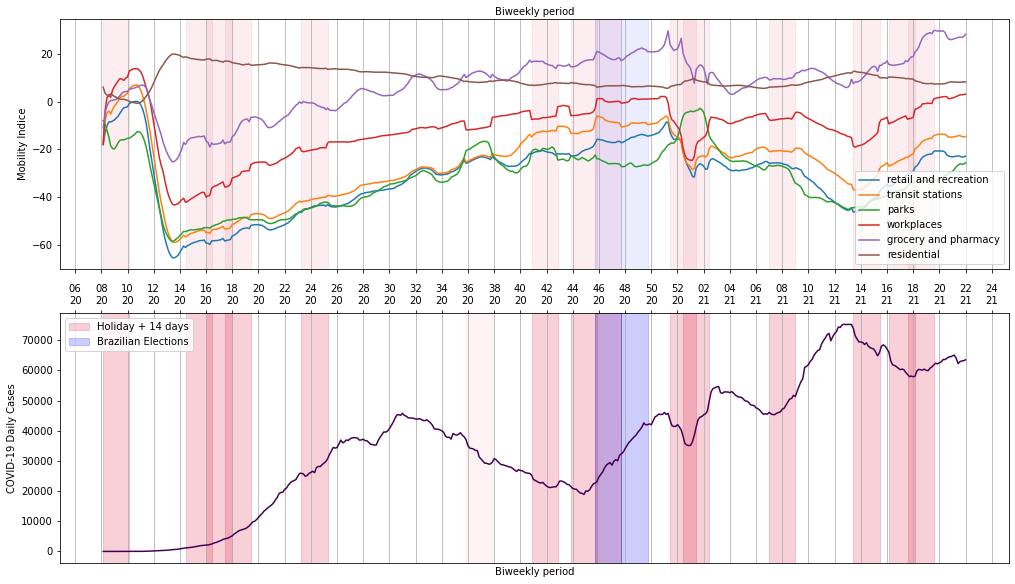

In [56]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(17, 10))

ax1.plot(df_mobility['retail and recreation'].rolling(moving_average, min_periods=1).mean(), label='retail and recreation')
ax1.plot(df_mobility['transit stations'].rolling(moving_average, min_periods=1).mean(), label='transit stations')
ax1.plot(df_mobility['parks'].rolling(moving_average, min_periods=1).mean(), label='parks')
ax1.plot(df_mobility['workplaces'].rolling(moving_average, min_periods=1).mean(), label='workplaces')
ax1.plot(df_mobility['grocery and pharmacy'].rolling(moving_average, min_periods=1).mean(), label='grocery and pharmacy')
ax1.plot(df_mobility['residential'].rolling(moving_average, min_periods=1).mean(), label='residential')
ax1.set_ylabel("Mobility Indice")
ax1.grid(axis='x')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax1.set_xlabel("Biweekly period")
ax1.xaxis.set_label_position('top')
ax1.legend(loc=4)


for i in range(len(holiday)):
    ax1.axvspan(datetime.datetime.strptime(holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Brazilian Elections",
               color="crimson", 
               alpha=0.075)
    
for i in range(len(elections)):
    ax1.axvspan(datetime.datetime.strptime(elections[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(elections[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Brazilian Elections",
               color="blue", 
               alpha=0.075)

ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%W\n%y'))
ax1.set_xticklabels([])
ax2.plot(df_parameters_seird['cases'].rolling(moving_average, min_periods=1).mean(), 
         color=plt.cm.viridis(0))

# ax2.plot(df_parameters_seird['Date'], 
#          df_parameters_seird['deaths'].rolling(moving_average, min_periods=1).mean(), 
#          color=plt.cm.viridis(1),
#          label='COVID-19 Daily Deaths')

ax2.grid(axis='x')

ax2.set_xlabel("Biweekly period")
ax2.set_ylabel("COVID-19 Daily Cases")

#ax2.set_xticklabels([])
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('bottom')

ax2.xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%W\n%y'))

for i in range(len(holiday)):
    ax2.axvspan(datetime.datetime.strptime(holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.2)
    
for i in range(len(elections)):
    ax2.axvspan(datetime.datetime.strptime(elections[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(elections[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Brazilian Elections",
               color="blue", 
               alpha=0.2)
    
for i in range(len(canceled_holiday)):
    ax2.axvspan(datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.05)

def remove_duplicate_labels_from_legends(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
remove_duplicate_labels_from_legends(ax2)

plt.subplots_adjust(hspace=0.175)

plt.savefig('./images/mobility.pdf', transparent=True)  
plt.show() 

---------------

# PCA

In [10]:
features = ['retail and recreation', 
            'grocery and pharmacy', 
            'parks', 
            'transit stations', 
            'workplaces', 
            'residential']

# Separating out the features
X = df_mobility.loc[:,features].values
X = StandardScaler().fit_transform(X)

In [108]:
pca.explained_variance_ratio_

array([0.79191094, 0.11060914, 0.06667454, 0.01761996, 0.00912477,
       0.00406065])

[0.79191094 0.11060914 0.06667454 0.01761996 0.00912477 0.00406065]
[0.79191094 0.90252008 0.96919462 0.98681458 0.99593935 1.        ]


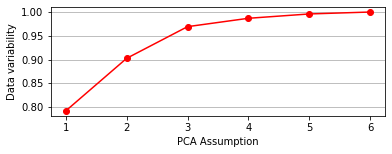

In [109]:
pca = PCA()
X_reduced = pca.fit_transform(X)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

fig = plt.figure(figsize=(6,2))
plt.plot(pca.explained_variance_ratio_.cumsum(), 'ro-')
plt.grid(axis='y')
plt.xticks([0,1, 2,3,4,5],[1, 2,3,4,5,6])
plt.xlabel('PCA Assumption')
plt.ylabel('Data variability')
plt.savefig('./images/mobility_pca_qtty.pdf', transparent=True, bbox_inches='tight', pad_inches=0)  
plt.show()

### Com 2 PCAs é possível generalizar os dados de mobilidade em 90%

In [11]:
pca_2comp = PCA(n_components=2)
principal_components = pca_2comp.fit_transform(X)
df_principal_components = pd.DataFrame(data = principal_components, columns=['pc1', 'pc2'])
df_principal_components.index = df_mobility.index

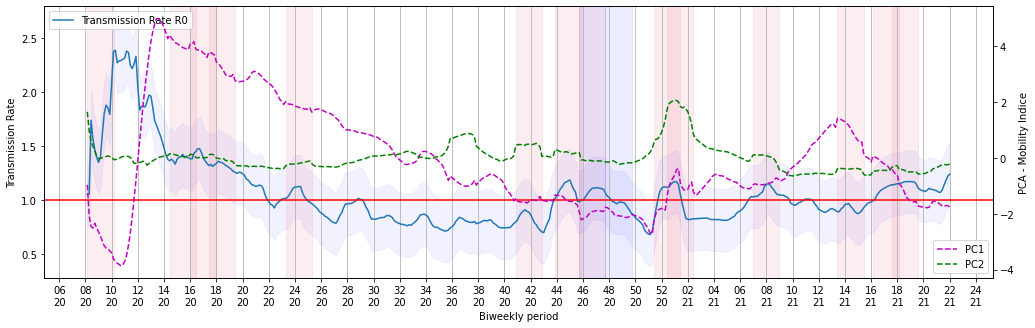

In [13]:
fig, ax = plt.subplots(figsize=(17, 5))

ax.plot(df_parameters_seird['R0_ma'], linestyle='-',label="Transmission Rate R0")
ax.axhline(y=1, color='r', linestyle='-')
ax.grid(axis='x')
ax.set_ylabel("Transmission Rate")
ax.set_xlabel("Biweekly period")
ax.legend(loc=2)

ci = 0.95 * np.std(df_parameters_seird['R0_ma'])/np.mean(df_parameters_seird['R0_ma'])

ax.fill_between(df_parameters_seird.index, 
                 (df_parameters_seird['R0_ma']-ci), 
                 (df_parameters_seird['R0_ma']+ci), 
                 color='b', 
                 alpha=.05)

ax1 = ax.twinx()
ax1.plot(df_principal_components['pc1'].rolling(moving_average, min_periods=1).mean(), color='m', linestyle='--', label='PC1')
ax1.plot(df_principal_components['pc2'].rolling(moving_average, min_periods=1).mean(), color='g', linestyle='--', label='PC2')
ax1.set_ylabel("PCA - Mobility Indice")
ax1.legend(loc=4)


for i in range(len(holiday)):
    ax.axvspan(datetime.datetime.strptime(holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Brazilian Elections",
               color="crimson", 
               alpha=0.075)
    
for i in range(len(elections)):
    ax.axvspan(datetime.datetime.strptime(elections[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(elections[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Brazilian Elections",
               color="blue", 
               alpha=0.075)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%W\n%y'))

plt.savefig('./images/transmission_rate_and_mobility_PCAs.pdf', transparent=True)  
plt.show() 

#### PCA with flag HOLIDAY - 1 and 0

In [14]:
df_principal_components['holiday'] = df_mobility['holiday']
df_principal_components['deaths'] = df_mobility.deaths
df_principal_components['r0'] = df_parameters_seird['R0_ma']

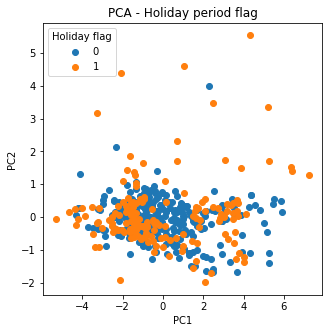

In [16]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

for n, grp in df_principal_components.groupby('holiday'):
    ax.scatter(x = "pc1", 
               y = "pc2", 
               data=grp, 
               label=n)

ax.set_title('PCA - Holiday period flag')
ax.legend(title="Holiday flag")
plt.show()

#### PCA with Ro > 1

In [122]:
df_principal_components_r0 = df_principal_components
df_principal_components_r0['R0>1'] = np.where(df_parameters_seird['R0_ma'] > 1, 1, 0)

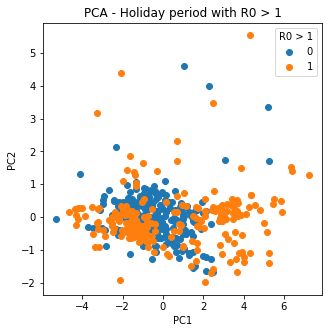

In [149]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

for n, grp in df_principal_components_r0.groupby('R0>1'):
    ax.scatter(x = "pc1", 
               y = "pc2", 
               data=grp, 
               label=n)

ax.set_title('PCA - Holiday period with R0 > 1')
ax.legend(title="R0 > 1")
plt.savefig('./images/pca_clustering_holiday_with_r0.pdf', transparent=True)  
plt.show()

#### PCA with Ro > 1 - only 2020

In [125]:
df_principal_components_r0_2020 = df_principal_components[df_principal_components.index <= '2020-12-31']

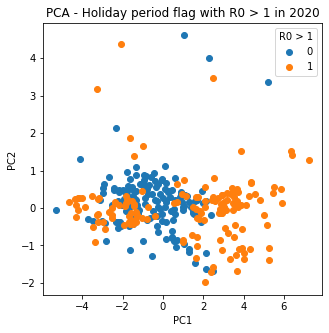

In [152]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

for n, grp in df_principal_components_r0_2020.groupby('R0>1'):
    ax.scatter(x = "pc1", 
               y = "pc2", 
               data=grp, 
               label=n)
    
ax.set_title('PCA - Holiday period flag with R0 > 1 in 2020')
ax.legend(title="R0 > 1")
plt.savefig('./images/pca_clustering_holiday_with_r0_2020.pdf', transparent=True)  
plt.show()

#### PCA with Ro > 1 - only 2021

In [129]:
df_principal_components_r0_2021 = df_principal_components[df_principal_components.index > '2020-12-31']

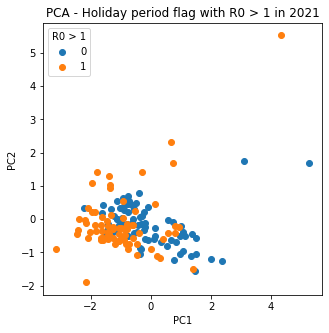

In [153]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

for n, grp in df_principal_components_r0_2021.groupby('R0>1'):
    ax.scatter(x = "pc1", 
               y = "pc2", 
               data=grp, 
               label=n)
    
ax.set_title('PCA - Holiday period flag with R0 > 1 in 2021')
ax.legend(title="R0 > 1")
plt.savefig('./images/pca_clustering_holiday_with_r0_2021.pdf', transparent=True)  
plt.show()